<a href="https://colab.research.google.com/github/drkfchen/ViT-Dementia/blob/main/Copy_of_Graph_cora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Relative Packages

In [ ]:
!pip install torch-geometric
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.0 MB/s eta 0:00:00


# 2. Load the Dataset - Cora

In [ ]:
# Load Cora dataset
dataset = Planetoid(root='Cora', name='Cora')

# Print dataset info
data = dataset[0]
print(f'Dataset: {dataset}')
print(f'Data: {data}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features per node: {data.num_node_features}')==
print(f'Number of classes: {dataset.num_classes}')


Processing...


Dataset: Cora()
Data: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433
Number of classes: 7


Done!


# 3. Define the GCN Model

In [ ]:
from torch_geometric.nn import GCNConv

class OriginalGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(OriginalGCN, self).__init__()
        # Using GCNConv without normalization
        self.conv1 = GCNConv(in_channels, hidden_channels, normalize=False)
        self.conv2 = GCNConv(hidden_channels, out_channels, normalize=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


class NormalizedGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(NormalizedGCN, self).__init__()
        # Using GCNConv with Laplacian normalization
        self.conv1 = GCNConv(in_channels, hidden_channels, normalize=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, normalize=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Instantiate model
origcn = OriginalGCN(dataset.num_features, 16, dataset.num_classes)
print(origcn)
norgcn = NormalizedGCN(dataset.num_features, 16, dataset.num_classes)
print(norgcn)


OriginalGCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
NormalizedGCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


# 4-1 Train/Test Dataset Split - Method from torch-geometric

In [ ]:
# Default data split in the Cora dataset
print("Default Data Split in Cora Dataset:")
print(f"Training Nodes: {data.train_mask.sum().item()}")   # 140 training nodes
print(f"Validation Nodes: {data.val_mask.sum().item()}")  # 500 validation nodes
print(f"Test Nodes: {data.test_mask.sum().item()}")       # 1000 test nodes

# Visualizing the split using different colors for train/val/test nodes
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

# Convert PyG graph to NetworkX format
G = to_networkx(data, to_undirected=True)

# Assign colors based on dataset split
colors = ['red' if data.train_mask[i] else 'blue' if data.val_mask[i] else 'green' for i in range(data.num_nodes)]

# Draw the graph
#plt.figure(figsize=(8, 6))
#nx.draw(G, node_color=colors, node_size=30, alpha=0.8, edge_color="gray")
#plt.title("Default Data Split (Red: Train, Blue: Validation, Green: Test)")
#plt.show()


Default Data Split in Cora Dataset:
Training Nodes: 140
Validation Nodes: 500
Test Nodes: 1000


# 4.2 Train/Test Dataset Split - Manually!


In [ ]:
# Define custom split ratios
train_ratio = 0.6  # 60% for training
val_ratio = 0.2    # 20% for validation
test_ratio = 1.0 - train_ratio - val_ratio  # Remaining 20% for testing

# Get the total number of nodes
num_nodes = data.num_nodes

# Shuffle node indices randomly
random_indices = torch.randperm(num_nodes)

# Split indices based on defined ratios
train_idx = random_indices[:int(train_ratio * num_nodes)]
val_idx = random_indices[int(train_ratio * num_nodes):int((train_ratio + val_ratio) * num_nodes)]
test_idx = random_indices[int((train_ratio + val_ratio) * num_nodes):]

# Create new masks for the custom split
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Assign nodes to the corresponding masks
data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

# Display the new data split
print("\nCustom Data Split:")
print(f"Training Nodes: {data.train_mask.sum().item()} ({train_ratio * 100:.1f}%)")
print(f"Validation Nodes: {data.val_mask.sum().item()} ({val_ratio * 100:.1f}%)")
print(f"Test Nodes: {data.test_mask.sum().item()} ({test_ratio * 100:.1f}%)")

# Visualizing the new custom split using colors
#plt.figure(figsize=(8, 6))
#colors = ['red' if data.train_mask[i] else 'blue' if data.val_mask[i] else 'green' for i in range(data.num_nodes)]
#nx.draw(G, node_color=colors, node_size=30, alpha=0.8, edge_color="gray")
#plt.title("Custom Data Split (Red: Train, Blue: Validation, Green: Test)")
#plt.show()



Custom Data Split:
Training Nodes: 1624 (60.0%)
Validation Nodes: 542 (20.0%)
Test Nodes: 542 (20.0%)


# 5. Define optimizer and loss function


In [ ]:
import torch
import torch.nn.functional as F

# Initialize models
model_original = OriginalGCN(dataset.num_features, 16, dataset.num_classes)
model_normalized = NormalizedGCN(dataset.num_features, 16, dataset.num_classes)

# Define optimizers
optimizer_original = torch.optim.Adam(model_original.parameters(), lr=0.01, weight_decay=5e-4)
optimizer_normalized = torch.optim.Adam(model_normalized.parameters(), lr=0.01, weight_decay=5e-4)
epochs = 100

def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate(model):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask]).item()
        pred = out.argmax(dim=1)
        correct = (pred[data.val_mask] == data.y[data.val_mask]).sum().item()
        val_acc = correct / data.val_mask.sum().item()
    return val_loss, val_acc

# Store losses for visualization
train_losses_original = []
train_losses_normalized = []

# Training loop
for epoch in range(epochs):
    # Train original model
    train_loss_original = train(model_original, optimizer_original)
    train_losses_original.append(train_loss_original)

    # Train normalized model
    train_loss_normalized = train(model_normalized, optimizer_normalized)
    train_losses_normalized.append(train_loss_normalized)

    # Validation every 20 epochs
    if epoch % 20 == 0:
        val_loss_original, val_acc_original = validate(model_original)
        val_loss_normalized, val_acc_normalized = validate(model_normalized)

        print(f'Original GCN - Val Loss: {val_loss_original:.4f}, Val Acc: {val_acc_original:.4f}')
        print(f'Normalized GCN - Val Loss: {val_loss_normalized:.4f}, Val Acc: {val_acc_normalized:.4f}')

Original GCN - Val Loss: 1.9803, Val Acc: 0.4225
Normalized GCN - Val Loss: 1.8668, Val Acc: 0.3764
Original GCN - Val Loss: 0.8308, Val Acc: 0.8081
Normalized GCN - Val Loss: 0.4484, Val Acc: 0.8801
Original GCN - Val Loss: 0.7155, Val Acc: 0.8339
Normalized GCN - Val Loss: 0.3592, Val Acc: 0.8819
Original GCN - Val Loss: 0.7962, Val Acc: 0.8321
Normalized GCN - Val Loss: 0.3779, Val Acc: 0.8764
Original GCN - Val Loss: 0.8829, Val Acc: 0.8506
Normalized GCN - Val Loss: 0.3885, Val Acc: 0.8801


# 6. Plot Loss Curve


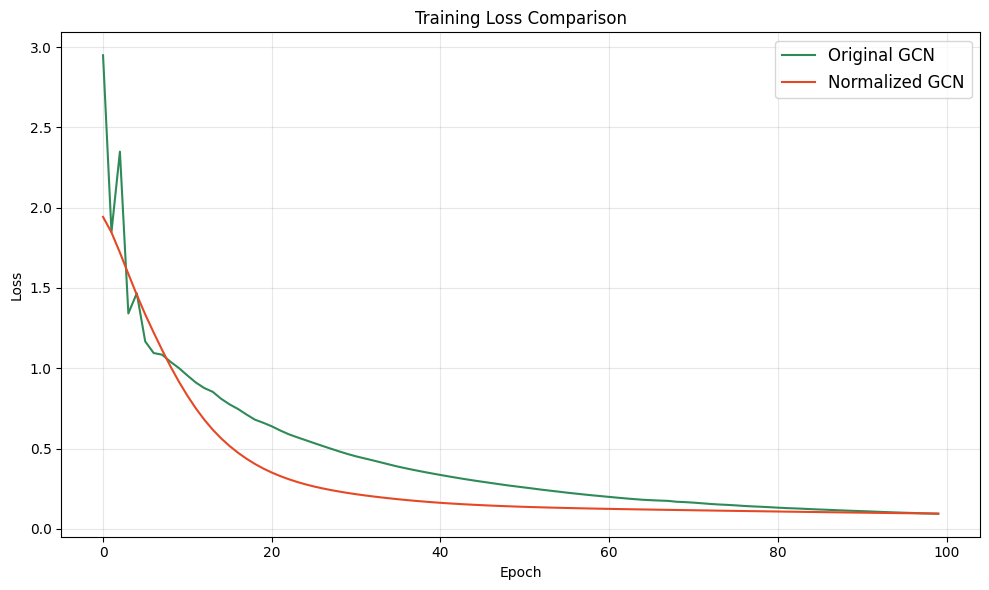

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot both loss curves
plt.plot(train_losses_original, label='Original GCN', color='#2E8B57')
plt.plot(train_losses_normalized, label='Normalized GCN', color='#E64825')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. Evaluating the Model on the Test Set (Using Multiple Metrics)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def test(model, name=""):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        out = model(data.x, data.edge_index)  # Forward pass
        pred = out.argmax(dim=1)  # Get predicted class labels
        # Get probability scores for AUC calculation
        probas = torch.softmax(out, dim=1)

        # Extract test set data
        y_true = data.y[data.test_mask].cpu()  # Ground truth labels for test set
        y_pred = pred[data.test_mask].cpu()  # Model predictions for test set
        y_probas = probas[data.test_mask].cpu()  # Probability scores for test set

        # 1. Accuracy (Overall classification accuracy)
        # Simple metric: number of correct predictions / total number of predictions
        test_acc = accuracy_score(y_true, y_pred)

        # 2. Macro averaging - Compute metrics for each label independently and then take the average
        # Treats all classes equally, regardless of their support (class imbalance)
        # Example: For binary case where class 1 has F1=0.9 (1000 samples) and class 2 has F1=0.7 (10 samples)
        # Macro-F1 = (0.9 + 0.7)/2 = 0.8
        test_macro_f1 = f1_score(y_true, y_pred, average='macro')
        test_macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        test_macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

        # 3. Micro averaging - Aggregate TP, FP, TN, FN for all classes and then compute metrics
        # Better for imbalanced datasets as it gives more weight to classes with more samples
        # For the above example, Micro-F1 would be closer to 0.9 since class 1 has more samples
        test_micro_f1 = f1_score(y_true, y_pred, average='micro')

        # 4. Weighted averaging - Similar to macro, but weighted by the number of samples per class
        # Accounts for class imbalance while still computing per-class metrics
        # For above example: Weighted-F1 = (0.9*1000 + 0.7*10)/(1000 + 10) ≈ 0.898
        test_weighted_f1 = f1_score(y_true, y_pred, average='weighted')

        # 5. ROC AUC Scores using different averaging methods
        try:
            # Macro ROC AUC - Simple average of per-class ROC AUC
            # Treats all classes equally regardless of class imbalance
            test_macro_auc = roc_auc_score(y_true, y_probas, average='macro', multi_class='ovr')

            # Weighted ROC AUC - Average of per-class ROC AUC weighted by class frequency
            # Accounts for class imbalance by giving more weight to larger classes
            test_weighted_auc = roc_auc_score(y_true, y_probas, average='weighted', multi_class='ovr')
        except ValueError:
            # Handle special cases (e.g., missing classes)
            test_macro_auc = float('nan')
            test_weighted_auc = float('nan')

        # Print results with clear labels
        print(f"\nTest Set Performance for {name}:")
        print(f"Accuracy          : {test_acc:.4f}")
        print(f"Macro-F1         : {test_macro_f1:.4f}")
        print(f"Macro-Precision  : {test_macro_precision:.4f}")
        print(f"Macro-Recall     : {test_macro_recall:.4f}")
        print(f"Micro-F1         : {test_micro_f1:.4f}")
        print(f"Weighted-F1      : {test_weighted_f1:.4f}")
        print(f"Macro-AUC        : {test_macro_auc:.4f}")
        print(f"Weighted-AUC     : {test_weighted_auc:.4f}")

# Run the test function for both models
test(model_original, "Original GCN")
test(model_normalized, "Normalized GCN")


Test Set Performance for Original GCN:
Accuracy          : 0.8321
Macro-F1         : 0.8108
Macro-Precision  : 0.8161
Macro-Recall     : 0.8105
Micro-F1         : 0.8321
Weighted-F1      : 0.8310
Macro-AUC        : 0.9575
Weighted-AUC     : 0.9585

Test Set Performance for Normalized GCN:
Accuracy          : 0.8727
Macro-F1         : 0.8583
Macro-Precision  : 0.8630
Macro-Recall     : 0.8600
Micro-F1         : 0.8727
Weighted-F1      : 0.8721
Macro-AUC        : 0.9783
Weighted-AUC     : 0.9781


# 8. Analyzing Performance Based on Node Degree

In [ ]:
import torch
from torch_geometric.utils import degree
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import torch.nn.functional as F

def plot_degree_groups(imbalanced_data, median_degree):
    """
    Plot degree distribution comparison between high and low degree groups,
    only showing degrees 0-10, based on global median_degree.
    """
    print("Plotting degree distribution...")
    degrees = degree(imbalanced_data.edge_index[0], num_nodes=imbalanced_data.num_nodes)

    low_degrees = degrees[degrees <= median_degree]
    high_degrees = degrees[degrees > median_degree]

    max_degree = 10
    low_degrees = low_degrees[low_degrees <= max_degree]
    high_degrees = high_degrees[high_degrees <= max_degree]

    plt.figure(figsize=(12, 6))
    bins = range(max_degree + 2)
    low_hist, _ = np.histogram(low_degrees.cpu().numpy(), bins=bins)
    high_hist, _ = np.histogram(high_degrees.cpu().numpy(), bins=bins)

    x = range(max_degree + 1)
    width = 0.35
    plt.bar(x, low_hist, width, label='Low Degree Group', color='skyblue', alpha=0.7)
    plt.bar(x, high_hist, width, label='High Degree Group', color='lightcoral', alpha=0.7)

    plt.title('Degree Distribution in Imbalanced Graph (Degrees ≤ 10)')
    plt.xlabel('Node Degree')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(x)
    plt.show()

def plot_performance_metrics(orig_results, norm_results):
    """
    Plot accuracy, F1-score, and AUC-ROC comparisons with exact values displayed.
    """
    print("Plotting performance comparison...")
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    metrics = ['accuracy', 'f1', 'auc_roc']
    titles = ['Accuracy by Node Group', 'F1-score by Node Group', 'AUC-ROC by Node Group']
    groups = ['Low Degree', 'High Degree']
    x = np.arange(len(groups))
    width = 0.25

    for i, metric in enumerate(metrics):
        orig_values = [orig_results['low'][metric], orig_results['high'][metric]]
        norm_values = [norm_results['low'][metric], norm_results['high'][metric]]

        bars1 = axes[i].bar(x - width, orig_values, width, label='Original GCN', color='skyblue')
        bars2 = axes[i].bar(x, norm_values, width, label='Normalized GCN', color='lightcoral')

        axes[i].set_ylabel(metric.capitalize())
        axes[i].set_title(titles[i])
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(groups)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

        # Add text labels on bars
        for bar in bars1:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}',
                         ha='center', va='bottom')

        for bar in bars2:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}',
                         ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


def create_imbalanced_graph(data):
    """
    Create imbalanced graph based on median degree split.
    """
    print("Creating imbalanced graph...")
    degrees = degree(data.edge_index[0], num_nodes=data.num_nodes)
    median_degree = degrees.median()

    low_degree_nodes = torch.where(degrees <= median_degree)[0]
    high_degree_nodes = torch.where(degrees > median_degree)[0]
    selected_nodes = torch.cat([low_degree_nodes, high_degree_nodes])

    old_to_new = torch.full((data.num_nodes,), -1, dtype=torch.long)
    old_to_new[selected_nodes] = torch.arange(len(selected_nodes))

    edge_mask = (old_to_new[data.edge_index[0]] >= 0) & (old_to_new[data.edge_index[1]] >= 0)
    new_edge_index = old_to_new[data.edge_index[:, edge_mask]]

    num_selected = len(selected_nodes)
    perm = torch.randperm(num_selected)
    train_size = int(0.5 * num_selected)
    val_size = int(0.2 * num_selected)

    new_train_mask = torch.zeros(num_selected, dtype=torch.bool)
    new_val_mask = torch.zeros(num_selected, dtype=torch.bool)
    new_test_mask = torch.zeros(num_selected, dtype=torch.bool)

    new_train_mask[perm[:train_size]] = True
    new_val_mask[perm[train_size:train_size + val_size]] = True
    new_test_mask[perm[train_size + val_size:]] = True

    print(f"Graph created with {num_selected} nodes (Low: {len(low_degree_nodes)}, High: {len(high_degree_nodes)})")
    print(f"Training nodes: {new_train_mask.sum().item()}, Validation nodes: {new_val_mask.sum().item()}, Test nodes: {new_test_mask.sum().item()}")

    imbalanced_data = Data(
        x=data.x[selected_nodes],
        edge_index=new_edge_index,
        y=data.y[selected_nodes],
        train_mask=new_train_mask,
        val_mask=new_val_mask,
        test_mask=new_test_mask
    )

    return imbalanced_data, median_degree


def evaluate_models(model_original, model_normalized, imbalanced_data, median_degree):
    """
    Evaluate models based on median degree split.
    """
    print("Evaluating models...")

    def evaluate_single_model(model, data):
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)
            pred_proba = F.softmax(out, dim=1)

            degrees = degree(data.edge_index[0], num_nodes=data.num_nodes)
            test_mask = data.test_mask
            test_degrees = degrees[test_mask]
            test_pred = pred[test_mask]
            test_true = data.y[test_mask]
            test_proba = pred_proba[test_mask]

            low_mask = test_degrees <= median_degree
            high_mask = test_degrees > median_degree

            degree_groups = {'low': low_mask, 'high': high_mask}
            results = {}
            for group_name, group_mask in degree_groups.items():
                if group_mask.sum().item() == 0:
                    continue
                group_pred = test_pred[group_mask]
                group_true = test_true[group_mask]
                group_proba = test_proba[group_mask]

                auc_scores = []
                for class_idx in range(test_proba.shape[1]):
                    if len(torch.unique(group_true)) > 1:
                        auc = roc_auc_score((group_true.cpu() == class_idx).float(),
                                            group_proba[:, class_idx].cpu(),
                                            multi_class='ovr')
                        auc_scores.append(auc)
                mean_auc = np.mean(auc_scores) if auc_scores else 0.0

                results[group_name] = {
                    'accuracy': accuracy_score(group_true.cpu(), group_pred.cpu()),
                    'f1': f1_score(group_true.cpu(), group_pred.cpu(), average='macro'),
                    'auc_roc': mean_auc,
                    'count': group_mask.sum().item(),
                    'avg_degree': test_degrees[group_mask].mean().item()
                }
        return results

    orig_results = evaluate_single_model(model_original, imbalanced_data)
    norm_results = evaluate_single_model(model_normalized, imbalanced_data)
    print("Model evaluation completed.")
    return orig_results, norm_results

def train_model(model, data, epochs=100, lr=0.001):
    """
    Train the model on the new data split
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            train_acc = accuracy_score(
                data.y[data.train_mask].cpu(),
                out[data.train_mask].argmax(dim=1).cpu()
            )
            print(f'Epoch {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}')

Creating imbalanced graph...
Creating imbalanced graph...
Graph created with 2708 nodes (Low: 1621, High: 1087)
Training nodes: 1354, Validation nodes: 541, Test nodes: 813

Plotting degree distribution...
Plotting degree distribution...


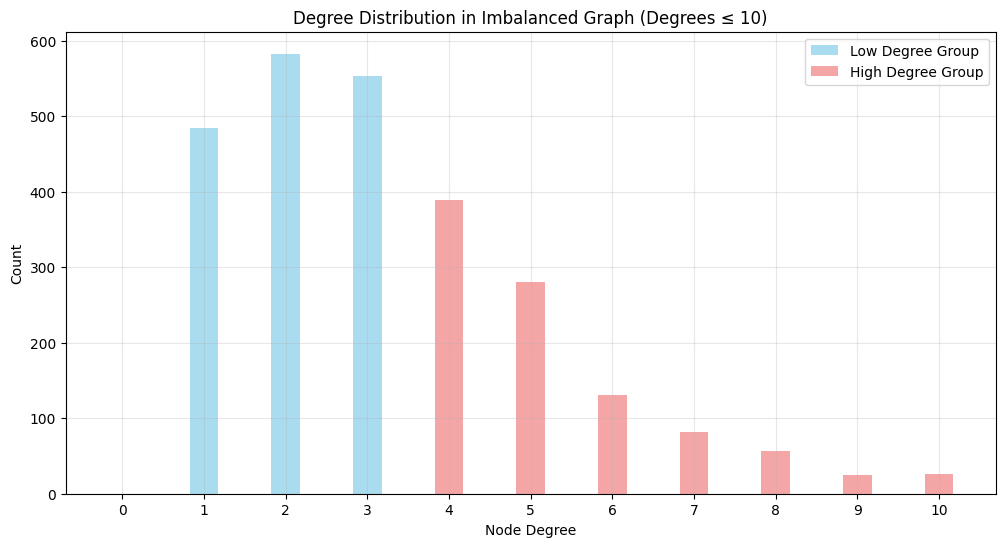

In [ ]:
print("Creating imbalanced graph...")
imbalanced_data, median_degree = create_imbalanced_graph(data)

print("\nPlotting degree distribution...")
plot_degree_groups(imbalanced_data, median_degree)


In [ ]:
print("\nTraining original model...")
train_model(model_original, imbalanced_data)

print("\nTraining normalized model...")
train_model(model_normalized, imbalanced_data)


Training original model...
Epoch 050, Loss: 0.1132, Train Acc: 0.9749
Epoch 100, Loss: 0.0564, Train Acc: 0.9904

Training normalized model...
Epoch 050, Loss: 0.1243, Train Acc: 0.9645
Epoch 100, Loss: 0.0798, Train Acc: 0.9808


In [ ]:
print("\nEvaluating models...")
orig_results, norm_results = evaluate_models(model_original, model_normalized, imbalanced_data, median_degree)



Evaluating models...
Evaluating models...
Model evaluation completed.



Plotting performance comparison...
Plotting performance comparison...


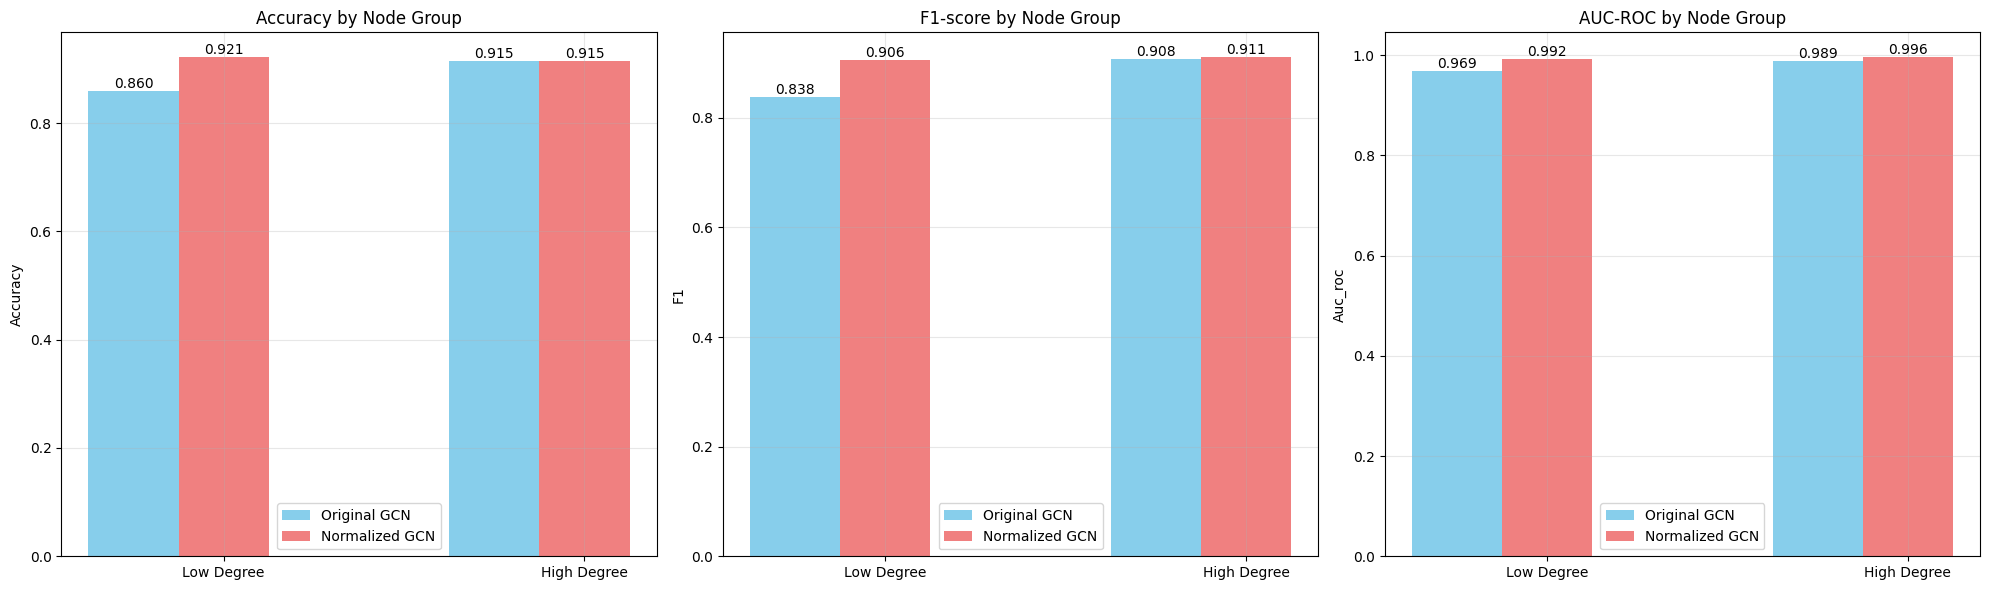

In [ ]:
print("\nPlotting performance comparison...")
plot_performance_metrics(orig_results, norm_results)

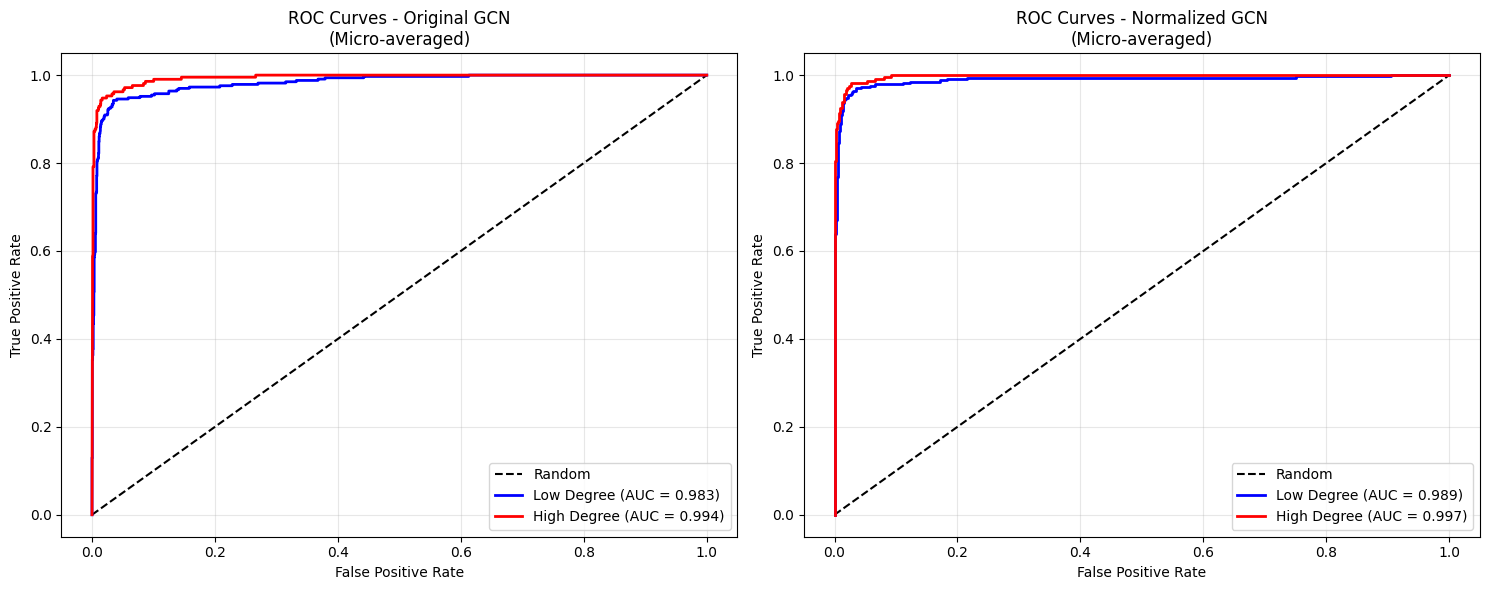

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
from torch_geometric.utils import degree
import numpy as np

def plot_model_roc_curves(model_original, model_normalized, data, median_degree):
    """
    Plot ROC curves for both models using micro-averaging for multi-class,
    ensuring high/low degree split is consistent with dataset creation.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    def plot_model_roc(model, ax, title):
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            pred_proba = torch.nn.functional.softmax(out, dim=1)

            # Get node degrees
            degrees = degree(data.edge_index[0], num_nodes=data.num_nodes)

            # Use median degree for consistent high/low split
            low_mask = degrees <= median_degree
            high_mask = degrees > median_degree

            # Get test predictions
            test_mask = data.test_mask
            test_true = data.y[test_mask].cpu().numpy()
            test_proba = pred_proba[test_mask].cpu().numpy()
            n_classes = pred_proba.shape[1]

            # Binarize the labels
            test_true_bin = label_binarize(test_true, classes=range(n_classes))

            # Plot for each group
            ax.plot([0, 1], [0, 1], 'k--', label='Random')
            colors = {'low': 'blue', 'high': 'red'}

            for group_name, group_mask in [('low', low_mask), ('high', high_mask)]:
                # Get mask for test nodes in this group
                test_group_mask = group_mask[test_mask].cpu().numpy()

                if np.any(test_group_mask):
                    # Compute micro-average ROC curve and ROC area
                    fpr, tpr, _ = roc_curve(
                        test_true_bin[test_group_mask].ravel(),
                        test_proba[test_group_mask].ravel()
                    )
                    roc_auc = auc(fpr, tpr)

                    ax.plot(fpr, tpr, color=colors[group_name],
                            label=f'{group_name.capitalize()} Degree (AUC = {roc_auc:.3f})',
                            linewidth=2)

            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'ROC Curves - {title}\n(Micro-averaged)')
            ax.legend()
            ax.grid(True, alpha=0.3)

    plot_model_roc(model_original, ax1, 'Original GCN')
    plot_model_roc(model_normalized, ax2, 'Normalized GCN')

    plt.tight_layout()
    plt.show()


# 使用方式：
plot_model_roc_curves(model_original, model_normalized, data, median_degree)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import random

def visualize_graph_structure(data, sample_size=100):
    # Create full graph first to calculate degrees
    full_G = nx.Graph()
    full_G.add_nodes_from(range(data.num_nodes))
    edge_list = data.edge_index.t().cpu().numpy()
    full_G.add_edges_from([(int(src), int(dst)) for src, dst in edge_list])

    # Calculate node degrees
    degrees = dict(full_G.degree())

    # Create connected subgraph starting from highest degree nodes
    selected_nodes = set()
    G = nx.Graph()

    # Sort nodes by degree in descending order
    nodes_by_degree = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

    # Start with the highest degree node
    start_node = nodes_by_degree[0][0]
    selected_nodes.add(start_node)

    # Keep adding nodes that are connected to our selected nodes until we reach sample_size
    while len(selected_nodes) < sample_size:
        # Find all edges connected to our selected nodes
        new_edges = [(int(src), int(dst)) for src, dst in edge_list
                    if (src in selected_nodes and dst not in selected_nodes) or
                       (dst in selected_nodes and src not in selected_nodes)]

        if not new_edges:
            break

        # Sort potential new nodes by degree
        potential_nodes = set([n for edge in new_edges for n in edge]) - selected_nodes
        potential_nodes = sorted([(n, degrees[n]) for n in potential_nodes],
                               key=lambda x: x[1], reverse=True)

        # Add the highest degree node from potential nodes
        if potential_nodes:
            selected_nodes.add(potential_nodes[0][0])
        else:
            break

    # Create subgraph with selected nodes
    G.add_nodes_from(selected_nodes)
    sampled_edges = [(int(src), int(dst)) for src, dst in edge_list
                     if src in selected_nodes and dst in selected_nodes]
    G.add_edges_from(sampled_edges)

    # Create color map with three colors (train, validation, test)
    colors = []
    for i in G.nodes():
        if data.train_mask[i]:
            colors.append('#2E86C1')  # Blue for training
        elif data.val_mask[i]:
            colors.append('#27AE60')  # Green for validation
        else:
            colors.append('#E67E22')  # Orange for test

    # Visualization
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=2/np.sqrt(G.number_of_nodes()), iterations=50)

    nx.draw(G, pos,
           node_color=colors,
           node_size=300,
           width=1.0,
           alpha=0.8,
           with_labels=True,
           font_size=8,
           font_color='white',
           edge_color='gray')

    # Add legend with three colors
    train_patch = mpatches.Patch(color='#2E86C1', label='Train')
    val_patch = mpatches.Patch(color='#27AE60', label='Validation')
    test_patch = mpatches.Patch(color='#E67E22', label='Test')
    plt.legend(handles=[train_patch, val_patch, test_patch], fontsize=12)

    plt.title(f'Graph Structure ({G.number_of_nodes()} nodes)', fontsize=14)
    plt.show()

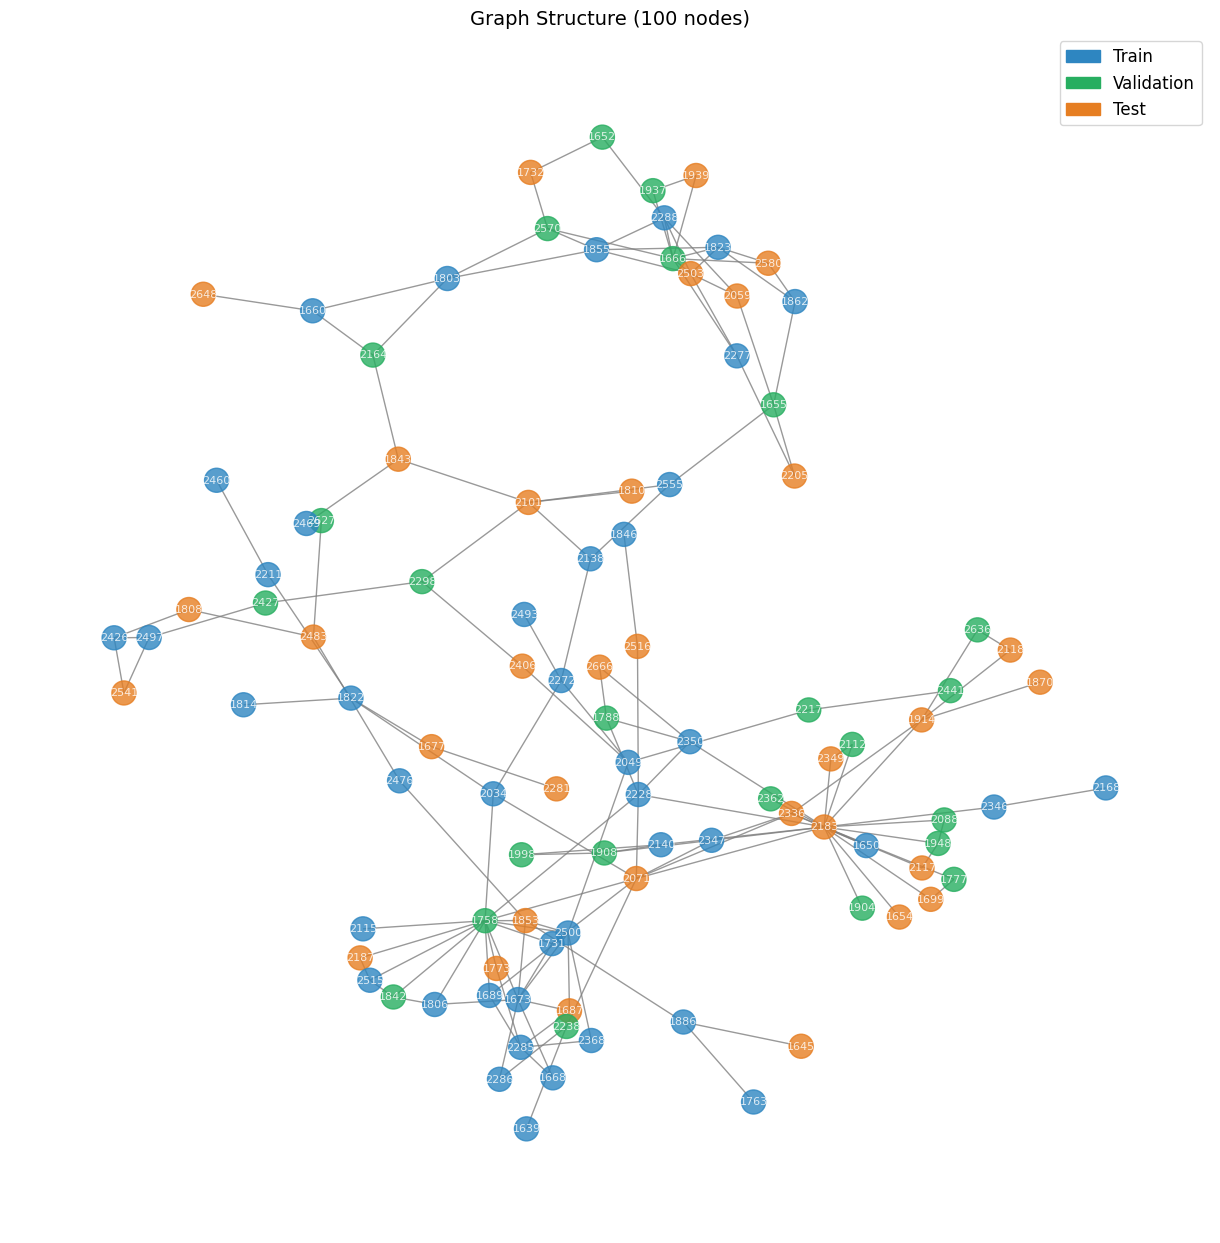

In [ ]:
visualize_graph_structure(imbalanced_data)


# 9. Comparison with Other Methods

Training KMeans...
KMeans Test Accuracy: 0.0590, Test F1: 0.0233, Test AUC-ROC: 0.0000
Training SVM...
SVM Test Accuracy: 0.6827, Test F1: 0.6653, Test AUC-ROC: 0.9100
Training MLP...
MLP Test Accuracy: 0.6771, Test F1: 0.6656, Test AUC-ROC: 0.9043
Plotting performance comparison...


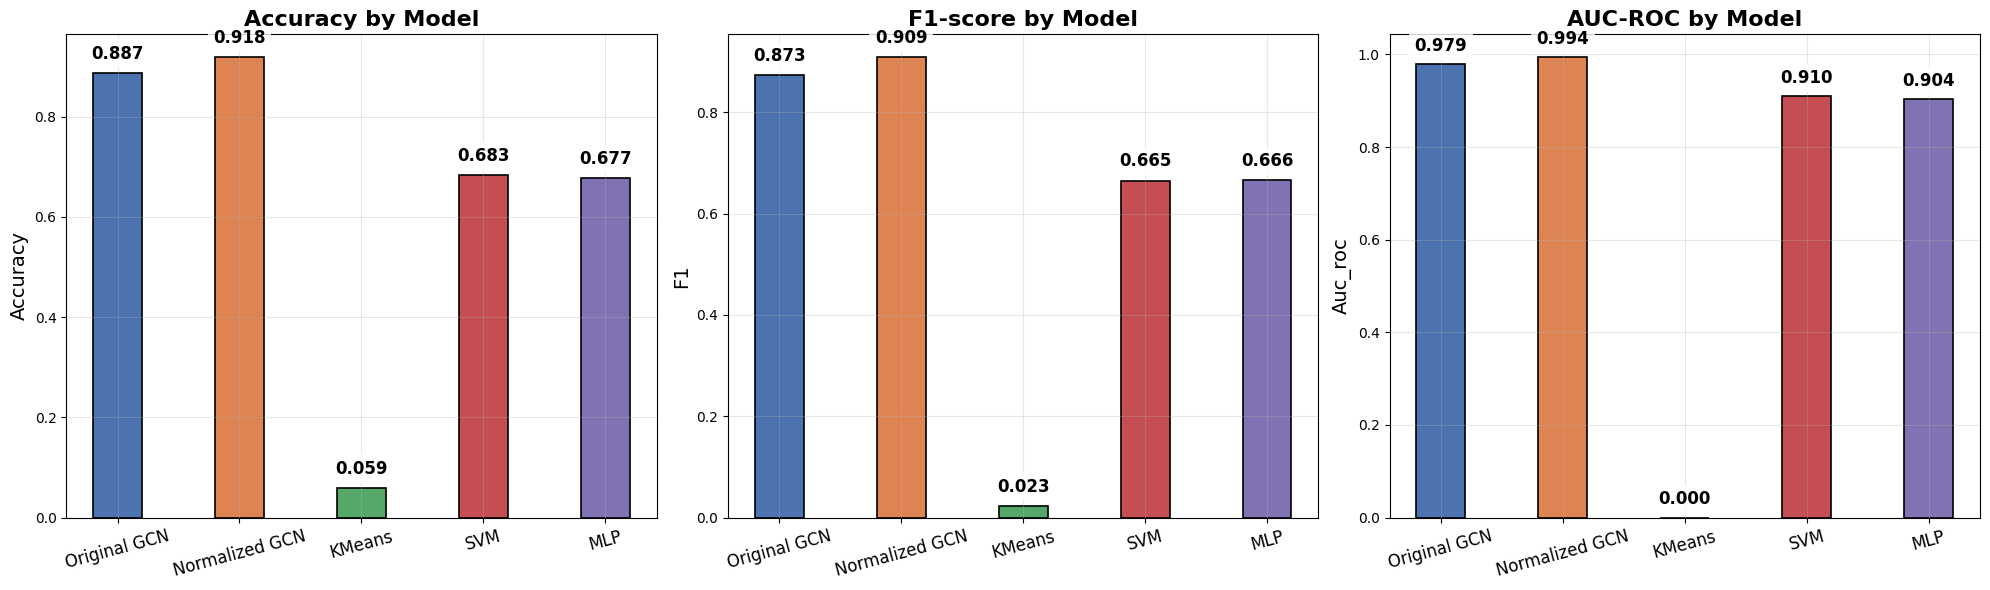

In [ ]:
import torch
import numpy as np
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch_geometric.utils import degree
from sklearn.preprocessing import StandardScaler


from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np

def plot_performance_metrics_all(orig_results, norm_results, ml_results):
    """
    Plot accuracy, F1-score, and AUC-ROC comparisons with exact values displayed.
    """
    print("Plotting performance comparison...")
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    metrics = ['accuracy', 'f1', 'auc_roc']  # Including AUC-ROC
    titles = ['Accuracy by Model', 'F1-score by Model', 'AUC-ROC by Model']
    models = ['Original GCN', 'Normalized GCN', 'KMeans', 'SVM', 'MLP']
    x = np.arange(len(models))
    width = 0.4
    colors = ['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3'] # Softer color scheme

    for i, metric in enumerate(metrics):
        orig_values = [orig_results['low'].get(metric, 0), orig_results['high'].get(metric, 0)]
        norm_values = [norm_results['low'].get(metric, 0), norm_results['high'].get(metric, 0)]

        ml_values = [ml_results[model].get(metric, 0.0) for model in ['KMeans', 'SVM', 'MLP']]
        all_values = [np.mean(orig_values), np.mean(norm_values)] + ml_values

        bars = axes[i].bar(x, all_values, width, color=colors, edgecolor='black', linewidth=1.2)

        axes[i].set_ylabel(metric.capitalize(), fontsize=14)
        axes[i].set_title(titles[i], fontsize=16, fontweight='bold')
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(models, rotation=15, fontsize=12)
        axes[i].grid(True, alpha=0.3)

        # Add text labels on bars (only the value, directly above each bar)
        for bar, value in zip(bars, all_values):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{value:.3f}',
                         ha='center', va='bottom', fontsize=12, fontweight='bold',
                         color='black', bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))


    plt.tight_layout()
    plt.show()



def prepare_ml_data(data, scaling_method="standard"):
    x = data.x.cpu().numpy()
    y = data.y.cpu().numpy()

    train_mask = data.train_mask.cpu().numpy()
    val_mask = data.val_mask.cpu().numpy()
    test_mask = data.test_mask.cpu().numpy()

    x_train, y_train = x[train_mask], y[train_mask]
    x_val, y_val = x[val_mask], y[val_mask]
    x_test, y_test = x[test_mask], y[test_mask]


    if scaling_method == "standard":
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()

    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)

    return x_train, y_train, x_val, y_val, x_test, y_test



def evaluate_ml_model(model, x_train, y_train, x_val, y_val, x_test, y_test):
    """
    Train and evaluate ML model, returning performance on test set.
    """
    model.fit(x_train, y_train)

    y_pred_test = model.predict(x_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test, average='macro')

    return {'accuracy': test_acc, 'f1': test_f1}


def compare_ml_models(data):
    """
    Compare multiple ML models using the same train/val/test split, including AUC-ROC.
    """
    x_train, y_train, x_val, y_val, x_test, y_test = prepare_ml_data(data)

    models = {
        'KMeans': KMeans(n_clusters=len(np.unique(y_train)), random_state=42),
        'SVM': SVC(kernel='linear', probability=True, random_state=42),
        'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, random_state=42)
    }

    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(x_train, y_train)

        y_pred_test = model.predict(x_test)
        y_proba_test = model.predict_proba(x_test) if hasattr(model, 'predict_proba') else None

        test_acc = accuracy_score(y_test, y_pred_test)
        test_f1 = f1_score(y_test, y_pred_test, average='macro')

        if y_proba_test is not None and len(np.unique(y_test)) > 1:
            test_auc = roc_auc_score(y_test, y_proba_test, multi_class='ovr')
        else:
            test_auc = 0.0  # Default if AUC-ROC can't be computed

        results[name] = {'accuracy': test_acc, 'f1': test_f1, 'auc_roc': test_auc}

        print(f"{name} Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}, Test AUC-ROC: {test_auc:.4f}")

    return results

results = compare_ml_models(data)

plot_performance_metrics_all(orig_results, norm_results, results)